In [2]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

import sklearn
from sklearn.mixture import BayesianGaussianMixture as BGM

plt.rcParams['pdf.fonttype']=42
ko_mice = stx.ymaze_sess_deets.ko_mice

ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
# ctrl_mice = [m for m in ctrl_mice if m not in ('mCherry6')]

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
figdir = "/mnt/BigDisk/YMazeResults/neural/across_day_shift"
os.makedirs(figdir,exist_ok=True)

In [4]:
def crosscorr_mat(trial_mat, inds = np.arange(-29,30)):
    # inds = np.arange(-99,100)
    cc_mat = np.nan*np.zeros([trial_mat.shape[0], trial_mat.shape[0], inds.shape[0]])
    for cell in range(trial_mat.shape[-1]):
        for trial0 in range(trial_mat.shape[0]):
            for trial1 in range(trial_mat.shape[0]):
                tmp = np.correlate(trial_mat[trial0,:,cell],trial_mat[trial1,:,cell],mode='full')
#                 if np.amax(tmp)>.2:
                cc_mat[trial0,trial1,:] += tmp
    
    return cc_mat/trial_mat.shape[-1], inds

def pv_crosscorr(trial_mat):
    
    tm_z = sp.stats.zscore(trial_mat, axis=-1)

    n_trials, n_pos, n_cells = trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[-1]  
    cc_mat = np.zeros((n_trials, n_trials, 2*n_pos-1))
    for t,tp in product(range(n_trials), range(n_trials)):

        _z_t, _z_tp = tm_z[t,:,:], tm_z[tp,:,:]
        z_t, z_tp = np.zeros((n_pos*3-2,n_cells)), _z_tp[:,:]
        z_t[n_pos-1:2*n_pos-1,:] = _z_t
        for shift in range(0, 2*n_pos-1):
            cc_mat[t,tp,shift] = np.nanmean(np.nanmean(z_tp*z_t[shift:shift+n_pos,:], axis=-1), axis=0)

    return cc_mat

def crosscorr_res(sess, key = 'spks_norm'):
    trial_mat = sp.ndimage.filters.gaussian_filter1d(sess.trial_matrices[key][:,:,:],1,axis=1)
    trial_mat[np.isnan(trial_mat)]=1E-5
    
    cc_mat = pv_crosscorr(trial_mat)
    
    return {'cc_mat': cc_mat,
            'trial_info': sess.trial_info,
            'speed': np.nanmean(sess.trial_matrices['speed'], axis=1)
           }    

def cc_com(cc_mat, inds = np.arange(-29,30)):
    return np.nansum(cc_mat*inds[np.newaxis,np.newaxis,:], axis=-1)/(np.nansum(cc_mat,axis=-1)+1E-3)

shift = lambda com: com*(np.tril(-1*np.ones(com.shape),k=-1) + np.triu(np.ones(com.shape), k=1))

def run_crosscorr(sess, nov=True, max_trial = 5, arm_only = False, smooth = 0, key='spks_norm'):
    if nov:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
    else:
        trial_mask = (-1*sess.trial_info['LR']==sess.novel_arm) & (sess.trial_info['block_number']==5)
                  
    com = np.nan*np.zeros([max_trial,max_trial])
    if arm_only:
        trial_mat = sess.trial_matrices[key][trial_mask,:,:][:max_trial,12:,:]
    else:
        trial_mat = sess.trial_matrices[key][trial_mask,:,:][:max_trial,:,:]
        
    trial_mat[np.isnan(trial_mat)]=1E-3
        
    if smooth>0:
        if arm_only:
            trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,12:,:]
        else:
            trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat, smooth, axis=1)[:max_trial,:,:]
        
    
    speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:,][:max_trial,:])
    cc_mat = pv_crosscorr(trial_mat)
    
    
    
    com[:trial_mat.shape[0], :trial_mat.shape[0]] = cc_com(cc_mat, inds = np.arange(-trial_mat.shape[1]+1,trial_mat.shape[1]))
    return {'cc_mat': cc_mat,
           'com': com,
           'shift': np.nanmean(shift(com)),
           'speed': speed}

In [5]:
ctrl_com = []
for mouse in ctrl_mice:
    concat_sess = u.single_mouse_concat_sessions(mouse,date_inds=np.arange(6))
    
    day_mat = np.zeros((6, *concat_sess.trial_matrices['spks'].shape[1:]))
    for day in range(6):
        trial_mask = (concat_sess.trial_info['LR']==concat_sess.novel_arm)*(concat_sess.trial_info['sess_num']==day)
        day_mat[day,:,:] = sp.ndimage.gaussian_filter1d(np.nanmean(concat_sess.trial_matrices['spks'][trial_mask,:,:],axis=0),1,axis=0)
        
    cc_mat = pv_crosscorr(day_mat)
    com = cc_com(cc_mat, inds = np.arange(-day_mat.shape[1]+1,day_mat.shape[1]))
    ctrl_com.append(com)
ctrl_com = np.array(ctrl_com)

29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel
04_12_2020 YMaze_LNovel
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel
04_12_2020 YMaze_LNovel
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel
04_12_2020 YMaze_LNovel
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel
04_12_2020 YMaze_LNovel
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


05_12_2020 YMaze_LNovel
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel


In [6]:
ko_com = []
for mouse in ko_mice:
    concat_sess = u.single_mouse_concat_sessions(mouse,date_inds=np.arange(6))
    
    day_mat = np.zeros((6, *concat_sess.trial_matrices['spks'].shape[1:]))
    for day in range(6):
        trial_mask = (concat_sess.trial_info['LR']==concat_sess.novel_arm)*(concat_sess.trial_info['sess_num']==day)
        day_mat[day,:,:] = sp.ndimage.gaussian_filter1d(np.nanmean(concat_sess.trial_matrices['spks'][trial_mask,:,:],axis=0),1,axis=0)
        
    cc_mat = pv_crosscorr(day_mat)
    com = cc_com(cc_mat, inds = np.arange(-day_mat.shape[1]+1,day_mat.shape[1]))
    ko_com.append(com)
ko_com = np.array(ko_com)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel
22_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel


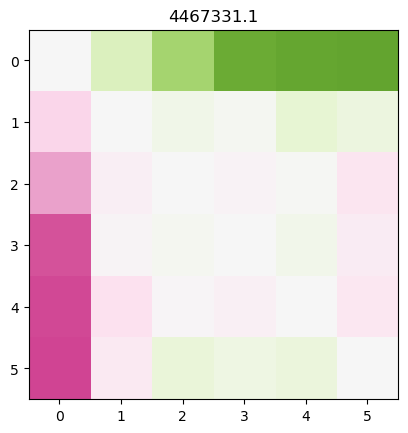

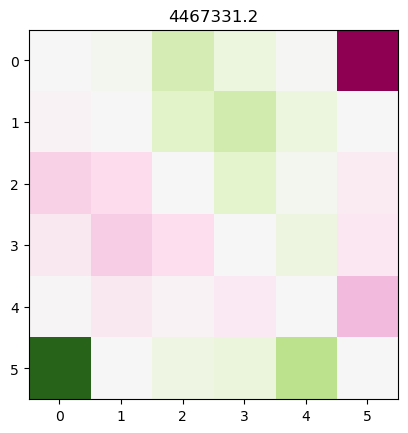

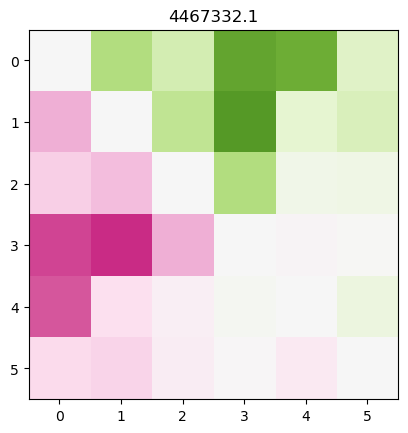

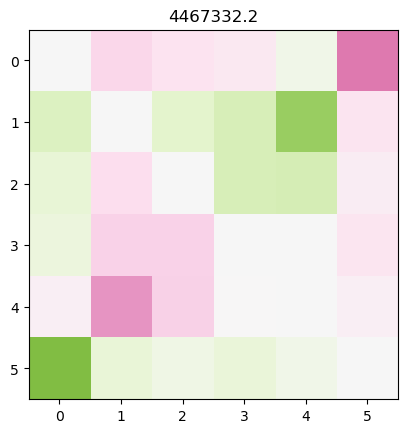

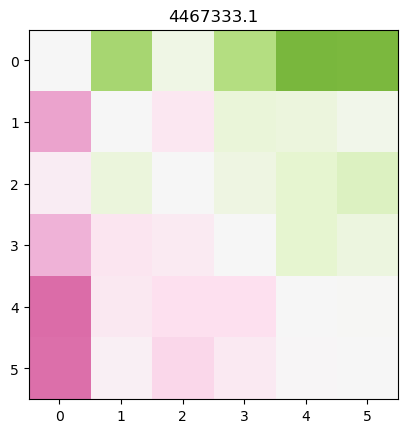

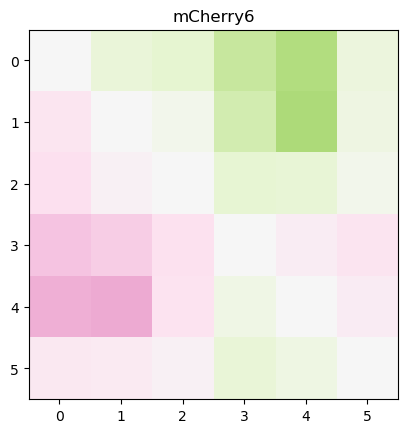

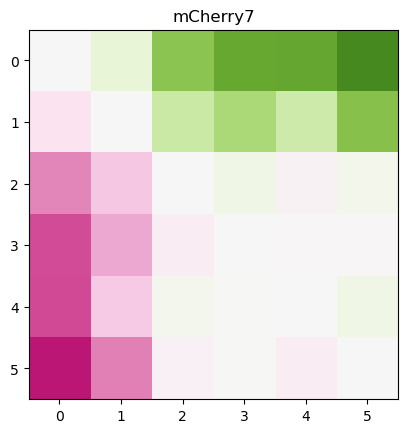

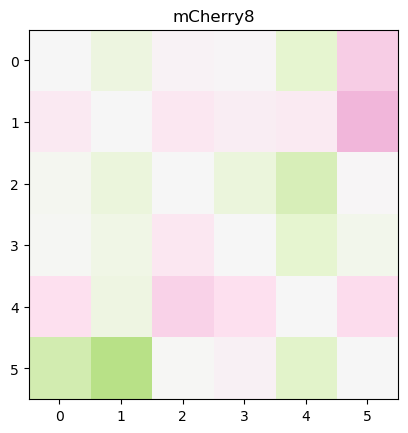

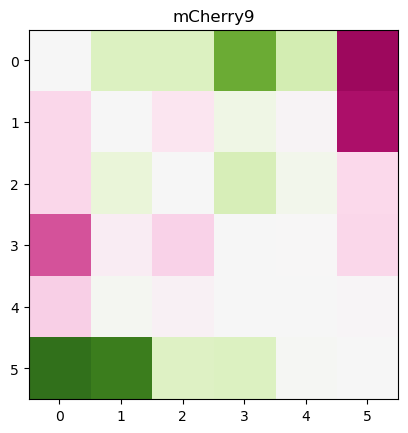

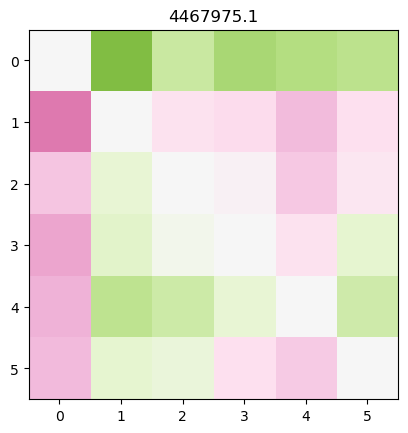

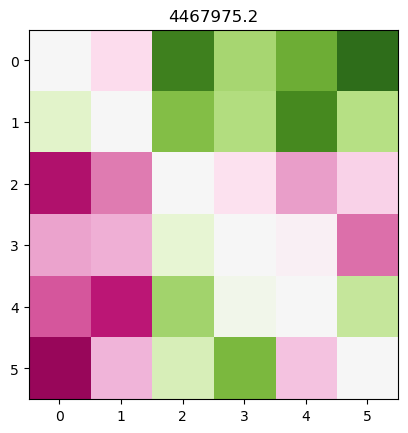

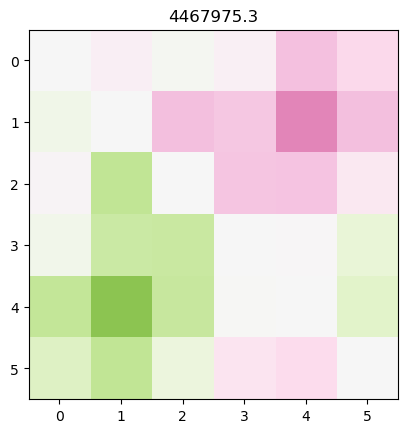

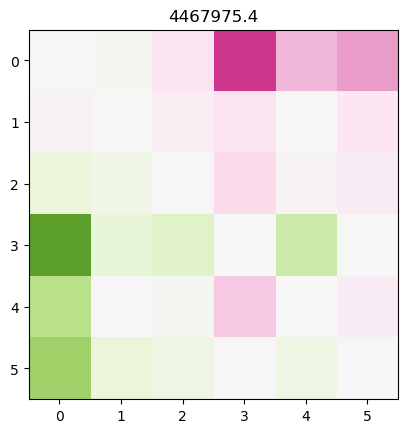

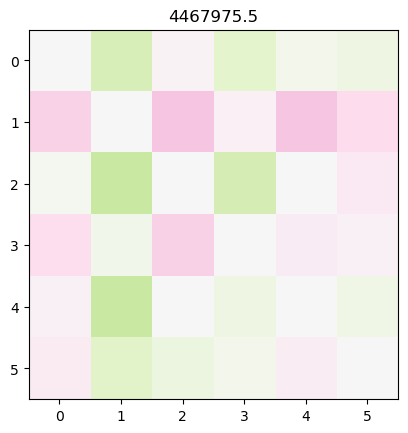

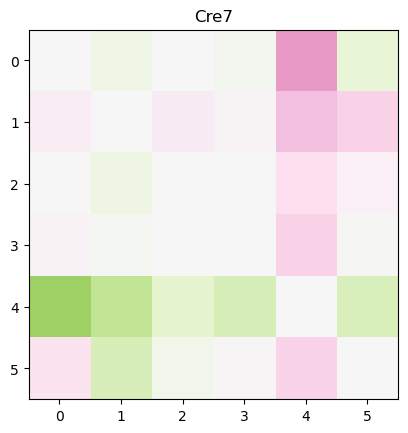

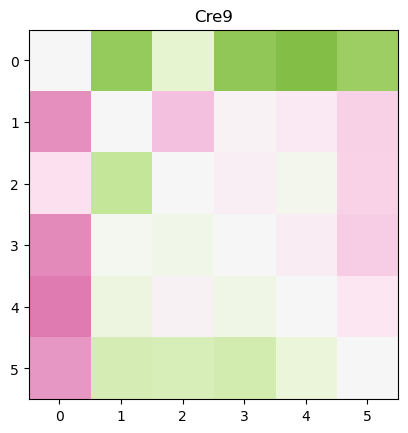

In [7]:
for m, mouse in enumerate(ctrl_mice):
    fig, ax = plt.subplots()
    ax.imshow(ctrl_com[m,:,:], vmin=-5, vmax=5, cmap='PiYG')
    ax.set_title(mouse)
    
for m, mouse in enumerate(ko_mice):
    fig, ax = plt.subplots()
    ax.imshow(ko_com[m,:,:], vmin=-5, vmax=5, cmap='PiYG')
    ax.set_title(mouse)
    
    

-3.0010532267445202 0.009531593762677355
-5.94872050015189 0.00034246879294864036
0.11162880889338503 0.9147584520999932


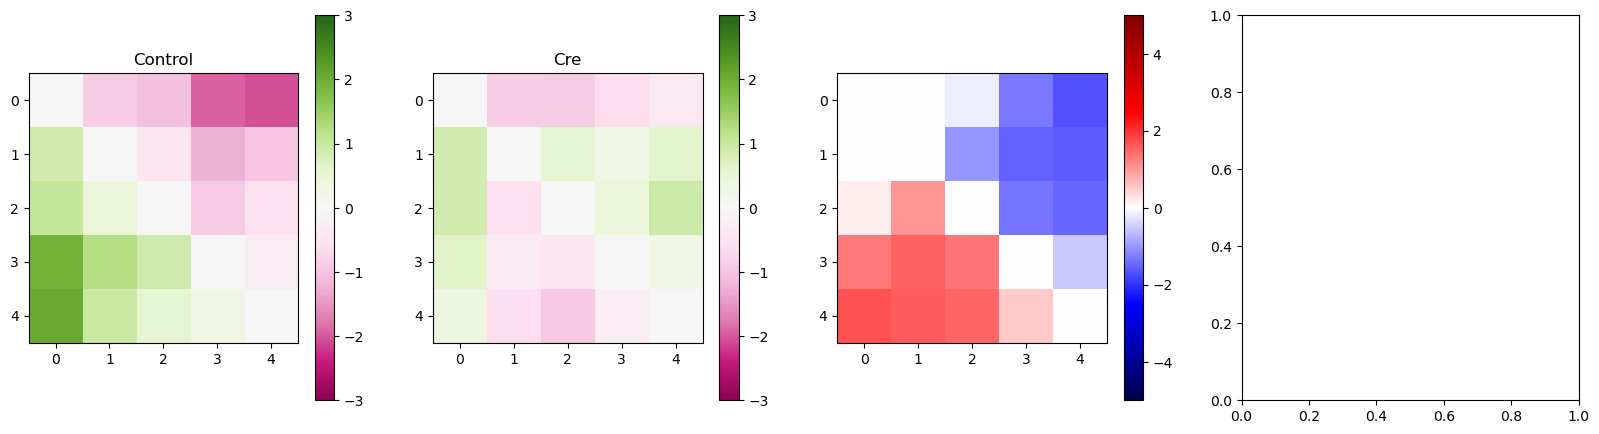

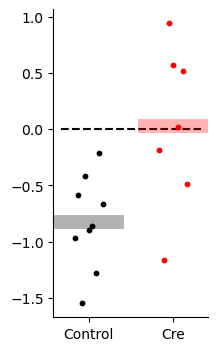

In [8]:
n_days = 5
fig, ax = plt.subplots(1,4, figsize=[20,5])
# ctrl_com = np.array(ctrl_com)
ctrl_com = ctrl_com[:,:n_days,:n_days]
ko_com = ko_com[:,:n_days,:n_days]
# ko_com = np.array(ko_com)
h = ax[0].imshow(-ctrl_com.mean(axis=0), vmin=-3,vmax=3, cmap='PiYG')
plt.colorbar(h, ax = ax[0])
ax[0].set_title('Control')
h = ax[1].imshow(-ko_com.mean(axis=0), vmin=-3,vmax=3, cmap='PiYG')
plt.colorbar(h, ax = ax[1])
ax[1].set_title('Cre')
h = ax[2].imshow(-ctrl_com.mean(axis=0)+ko_com.mean(axis=0), vmin=-5, vmax=5, cmap='seismic')
plt.colorbar(h, ax = ax[2])



sign_flip_arr= np.ones((n_days,n_days))
sign_flip_arr[np.tril_indices(n_days,k=-1)]=-1

fig.savefig(os.path.join(figdir, "nov_across_day_com_shift.pdf"))


ctrl_shift = np.array([np.nanmean((-ctrl_com[i, :, :]*sign_flip_arr).ravel()) for i, _ in enumerate(ctrl_mice)])
ko_shift = np.array([np.nanmean((-ko_com[i, :, :]*sign_flip_arr).ravel()) for i, _ in enumerate(ko_mice)])
t,p = sp.stats.ttest_ind(ctrl_shift,ko_shift)
print(t,p)
t,p = sp.stats.ttest_1samp(ctrl_shift,0)
print(t,p)
t,p = sp.stats.ttest_1samp(ko_shift,0)
print(t,p)

fig, ax = plt.subplots(figsize=[2,4])
ax.scatter(np.linspace(-.2,-.1, num=len(ctrl_mice)), ctrl_shift, color='black', s=10)
ax.scatter(np.linspace(.1,.2, num=len(ko_mice)), ko_shift, color='red', s=10)
ax.plot([-.25, -.05], ctrl_shift.mean()*np.array([1, 1]), linewidth=10, alpha=.3, color='black')
ax.plot([.05, .25], ko_shift.mean()*np.array([1, 1]), linewidth=10, alpha=.3, color='red')
ax.plot([-.25,.25], [0,0], 'k--', zorder=-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim([-.25, .25])
ax.set_xticks([-.15, .15], labels=['Control', 'Cre'])


fig.savefig(os.path.join(figdir, "nov_across_day_com_shift_summary.pdf"))


In [13]:
ctrl_com = []
for mouse in ctrl_mice:
    concat_sess = u.single_mouse_concat_sessions(mouse,date_inds=np.arange(6))
    
    day_mat = np.zeros((6, *concat_sess.trial_matrices['spks'].shape[1:]))
    for day in range(6):
        trial_mask = (concat_sess.trial_info['LR']==-1*concat_sess.novel_arm)*(concat_sess.trial_info['sess_num']==day)
        day_mat[day,:,:] = sp.ndimage.gaussian_filter1d(np.nanmean(concat_sess.trial_matrices['spks'][trial_mask,:,:],axis=0),1,axis=0)
        
    cc_mat = pv_crosscorr(day_mat)
    com = cc_com(cc_mat, inds = np.arange(-day_mat.shape[1]+1,day_mat.shape[1]))
    ctrl_com.append(com)
ctrl_com = np.array(ctrl_com)



ko_com = []
for mouse in ko_mice:
    concat_sess = u.single_mouse_concat_sessions(mouse,date_inds=np.arange(6))
    
    day_mat = np.zeros((6, *concat_sess.trial_matrices['spks'].shape[1:]))
    for day in range(6):
        trial_mask = (concat_sess.trial_info['LR']==-1*concat_sess.novel_arm)*(concat_sess.trial_info['sess_num']==day)
        day_mat[day,:,:] = sp.ndimage.gaussian_filter1d(np.nanmean(concat_sess.trial_matrices['spks'][trial_mask,:,:],axis=0),1,axis=0)
        
    cc_mat = pv_crosscorr(day_mat)
    com = cc_com(cc_mat, inds = np.arange(-day_mat.shape[1]+1,day_mat.shape[1]))
    ko_com.append(com)
ko_com = np.array(ko_com)

29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel
04_12_2020 YMaze_LNovel
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel
04_12_2020 YMaze_LNovel
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel
04_12_2020 YMaze_LNovel
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel
04_12_2020 YMaze_LNovel
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


05_12_2020 YMaze_LNovel
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
14_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
15_10_2021 YMaze_LNovel
16_10_2021 YMaze_LNovel
17_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel
22_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel
18_10_2021 YMaze_LNovel
19_10_2021 YMaze_LNovel
20_10_2021 YMaze_LNovel
21_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel
23_10_2021 YMaze_LNovel


-1.8681824561972886 0.08280774493714901
15.0 0.09073426573426574


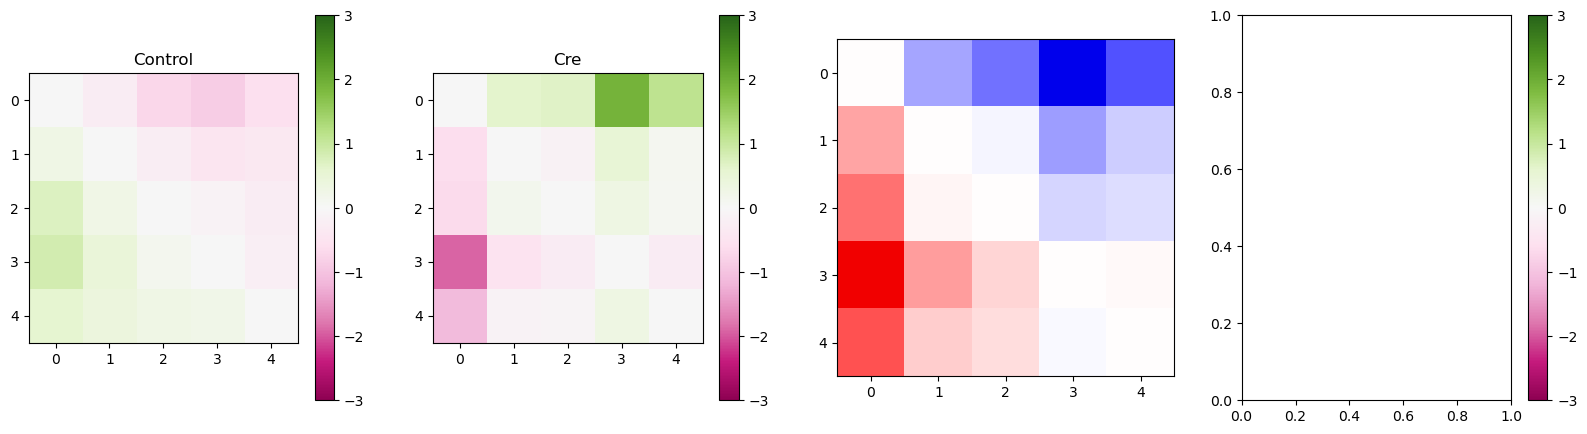

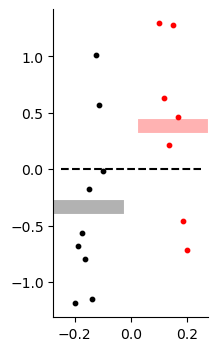

In [14]:
n_days = 5
fig, ax = plt.subplots(1,4, figsize=[20,5])
# ctrl_com = np.array(ctrl_com)
ctrl_com = ctrl_com[:,:n_days,:n_days]
ko_com = ko_com[:,:n_days,:n_days]
# ko_com = np.array(ko_com)
h = ax[0].imshow(-ctrl_com.mean(axis=0), vmin=-3,vmax=3, cmap='PiYG')
plt.colorbar(h, ax = ax[0])
ax[0].set_title('Control')
h = ax[1].imshow(-ko_com.mean(axis=0), vmin=-3,vmax=3, cmap='PiYG')
plt.colorbar(h, ax = ax[1])
ax[1].set_title('Cre')
ax[2].imshow(-ctrl_com.mean(axis=0)+ko_com.mean(axis=0), vmin=-5, vmax=5, cmap='seismic')
fig.colorbar(h, ax=ax[3])


sign_flip_arr= np.ones((n_days,n_days))
sign_flip_arr[np.tril_indices(n_days,k=-1)]=-1

fig.savefig(os.path.join(figdir, "fam_across_day_com_shift.pdf"))


ctrl_shift = np.array([np.nanmean((-ctrl_com[i, :, :]*sign_flip_arr).ravel()) for i, _ in enumerate(ctrl_mice)])
ko_shift = np.array([np.nanmean((-ko_com[i, :, :]*sign_flip_arr).ravel()) for i, _ in enumerate(ko_mice)])
t,p = sp.stats.ttest_ind(ctrl_shift,ko_shift)
print(t,p)
t,p = sp.stats.mannwhitneyu(ctrl_shift,ko_shift)
print(t,p)

fig, ax = plt.subplots(figsize=[2,4])
ax.scatter(np.linspace(-.2,-.1, num=len(ctrl_mice)), ctrl_shift, color='black', s=10)
ax.scatter(np.linspace(.1,.2, num=len(ko_mice)), ko_shift, color='red', s=10)
ax.plot([-.25, -.05], ctrl_shift.mean()*np.array([1, 1]), linewidth=10, alpha=.3, color='black')
ax.plot([.05, .25], ko_shift.mean()*np.array([1, 1]), linewidth=10, alpha=.3, color='red')
ax.plot([-.25,.25], [0,0], 'k--', zorder=-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim([-.25, .25])


fig.savefig(os.path.join(figdir, "fam_across_day_com_shift_summary.pdf"))